<a href="https://colab.research.google.com/github/djbradyAtOpticalSciencesArizona/computationalImaging/blob/master/waves/numericalDiffraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Analysis of diffraction between two planes
## David Brady
## University of Arizona
## May 2021

This notebook presents the angular spectrum method and Fresnel diffraction methods for modeling field propagation between two planes. 


## libraries

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]


# Angular spectrum diffraction

The field $g(x,y)$ at an output plane at $z=d$ is related to the field $f(x,y)$ at the input plane $z=0$ according to 
$$
g(x,y)={\cal F}^{-1}\left \lbrace F(u,v)e^{i2\pi z\sqrt{\frac{1}{\lambda^2}-u^2-v^2}}\right \rbrace
$$

This transformation may be implemented using the discrete Fourier transform. The sampling period $\Delta_x$ in the input plane is determined by the bandwidth of $f(x,y)$ and the number of samples in each dimension $N=\frac{2 X}{\Delta_x}$ is determined by the spatial support $[-X,X]$ of $f(x,y)$. With a simple transformation, the support of the output plane after the second Fourier transform is also $[-X,X]$ and the sampling period remains $\Delta_x$. Since the support of the field tends to grow by $2 d\frac{\lambda}{\Delta_x}$, it is necessary to zero pad the input plane by this spatial extent to avoid aliasing in the simulated diffracted field.

In [ ]:
def g(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1
#
  zPad=np.int(2*d*lam)
  inF=np.zeros(np.add(f.shape,[zPad,zPad]))
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

In [ ]:
N=30
lam=.3
f=np.ones([N,N])

Text(0, 0.5, 'wavelengths')

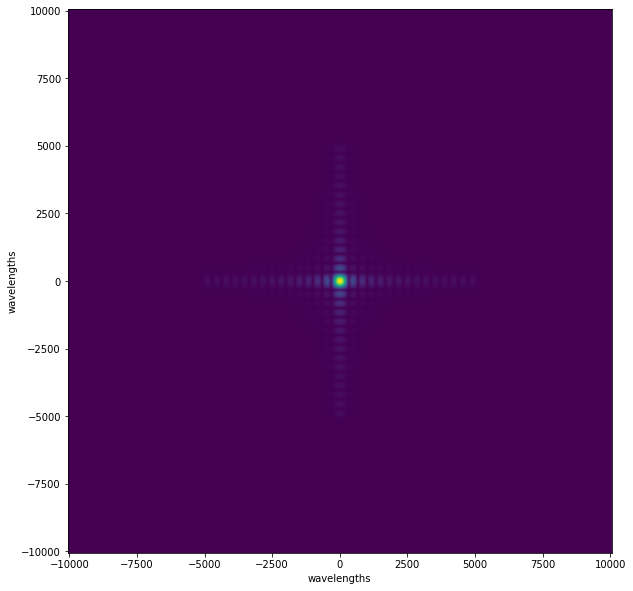

In [ ]:
q=g(f,10000,.3)
xrange=q.shape[0]/(lam*2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Text(0, 0.5, 'wavelengths')

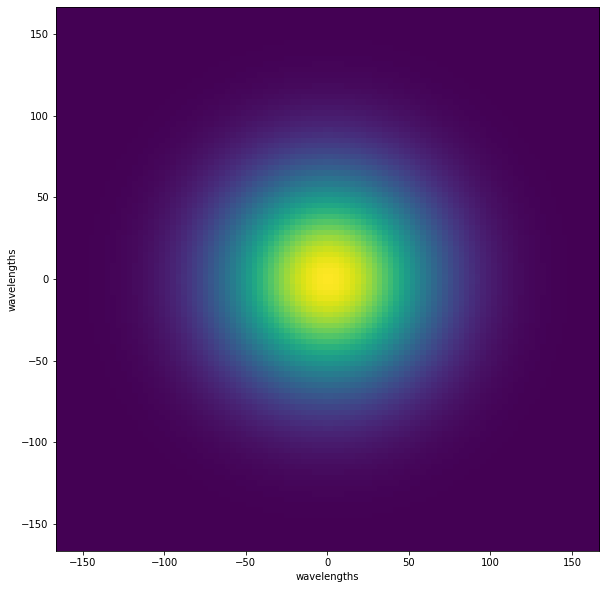

In [ ]:
N=100
lam=.3
xrange=N/(lam*2)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
f=np.exp(-(x**2+y**2)/4000)
plt.imshow(f,extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Text(0, 0.5, 'wavelengths')

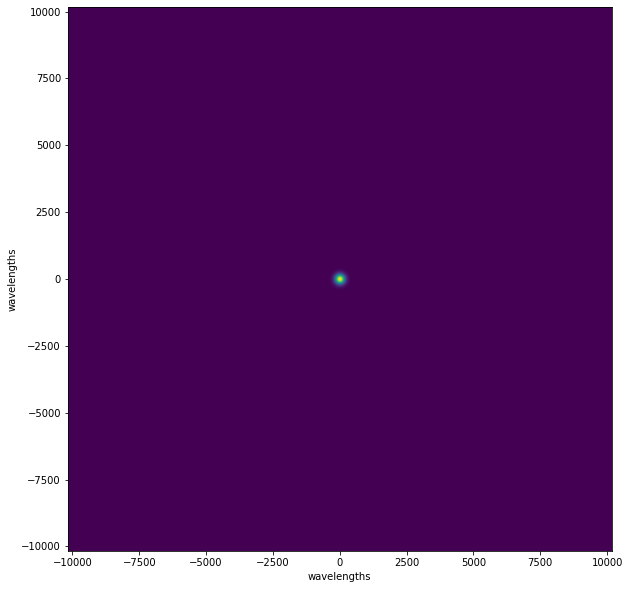

In [ ]:
q=g(f,10000,.3)
xrange=q.shape[0]/(lam*2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Text(0, 0.5, 'wavelengths')

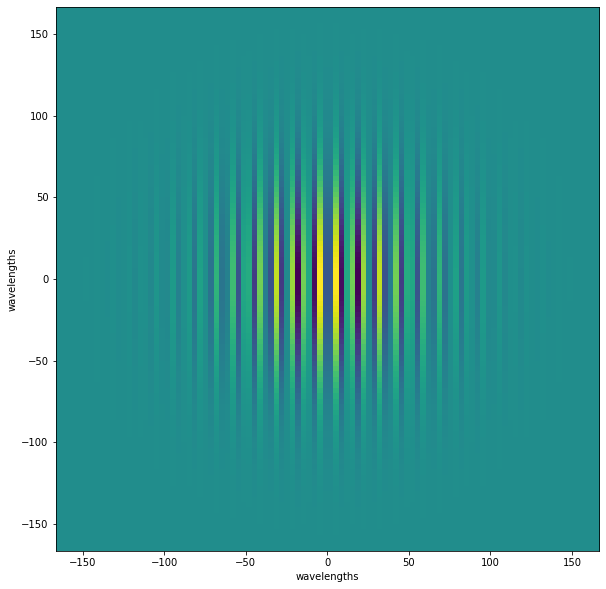

In [ ]:
N=100
lam=.3
xrange=N/(lam*2)
xp=np.linspace(-xrange,xrange,N)
x,y = np.meshgrid(xp,xp)
f=np.cos(2*np.pi*x)*np.exp(-(x**2+y**2)/4000)
plt.imshow(f,extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

Text(0, 0.5, 'wavelengths')

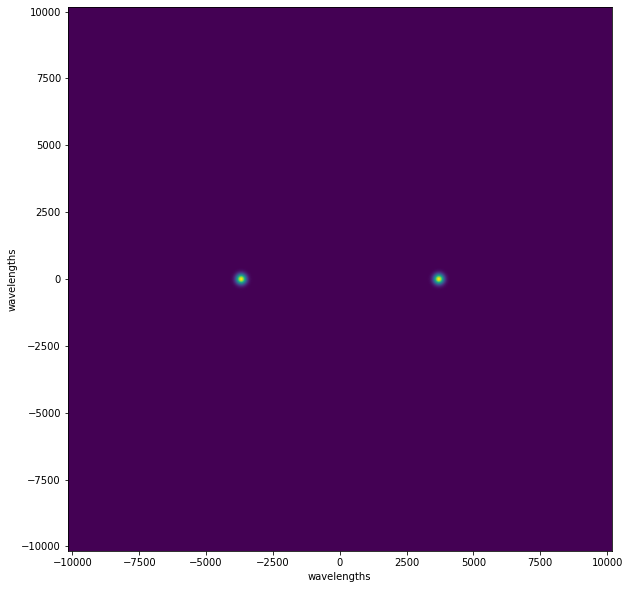

In [ ]:
q=g(f,10000,.3)
xrange=q.shape[0]/(lam*2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

## Fresnel Kernel Propagation

The angular spectrum method is effective and accurate in modeling diffraction to all ranges, but as range grows the need for larger zero padding makes the method numerically intractable. One can address this problem by modeling diffraction stages, propagating from one plane to the next with reasonable zero padding and then resampling the output plane to with a lower sampling rate to rescale the size of the Fourier transform needed in subsequent steps.

Another method to handle this problem relies expansion of the Fresnel kernel for diffraction, 
$$
h(x,y)=\frac{1}{i\lambda d} e^{i2\pi\frac{d}{\lambda}}e^{i\pi\frac{x^2+y^2}{\lambda d}}
$$
Convolution of the input field $f(x,y)$ with this kernel can be written 
$$
\begin{split}
g(x',y')&=\frac{1}{i\lambda d} e^{i2\pi\frac{d}{\lambda}}\int\int f(x,y)e^{i\pi\frac{(x-x')^2+(y-y')^2}{\lambda d}}dxdy\\
&=\frac{1}{i\lambda d} e^{i2\pi\frac{d}{\lambda}}e^{i\pi\frac{x'^2+y'^2}{\lambda d}}\int\int f(x,y)e^{i\pi\frac{x^2+y^2}{\lambda d}}e^{-i2\pi\frac{x'x+y'y}{\lambda d}}dxdy
\end{split}
$$
Using this equation we can model diffraction by taking a single Fourier transform of an appropriately modulated input field. The maximum period for the quadratic phase modulation in the input plane is $\lambda d/X$, where $X$ is the limit of the input aperture. Considering $d>\Delta_x X/\lambda$, sampling at the rate appropriate to characterize $f(x,y)$ will be sufficient. 

Taking the discrete Fourier transform with $N$ samples covering the range $[-X,X]$ with samples spaced by $\Delta_x$ in the input space of this system yields an output space of $N$ samples spaced by $\Delta_{x'}=\frac{\lambda d}{2X}$ covering the range $[-\frac{\lambda d}{2\Delta_x},\frac{\lambda d}{2\Delta_x}]$ 

In [22]:
def gFT(f,d,lam):
#
# calculate the diffracted field for the 2d image f propagated a distance d with wavelength relative to the pixel pitch lam
# d is in units of wavelengths, lam is the ratio of the wavelength to the sampling period. We assume lam<< 1 and d>N/(2 lam^2)
#
# f is a square matrix with samples spaced by 1/lam
#
  xrange=f.shape[0]/(lam*2)
  xprange=f.shape[0]*d/(4*xrange)
  xin=np.linspace(-xrange,xrange,N)
  xout=np.linspace(-xprange,xprange,N)
  x,y=np.meshgrid(xin,xin)
  xp,yp=np.meshgrid(xout,xout)
  g=np.exp(1j*np.pi*(xp**2+yp**2)/d)*np.fft.fftshift(np.fft.fft2(f*np.exp(1j*np.pi*(xp**2+yp**2)/d)))
  return g

d \lambda /\Delta_x X =  3.515625


Text(0, 0.5, 'wavelengths')

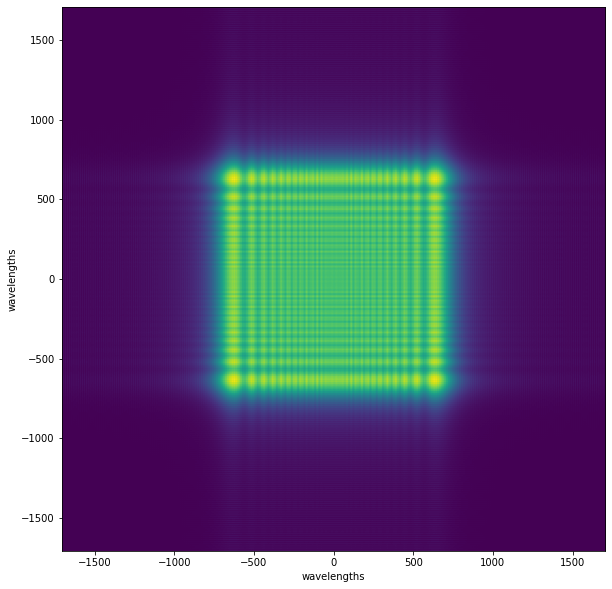

In [23]:
N=1024
lam=.3
d=20000
print("d \lambda /\Delta_x X = ", 2*d*lam**2/N)
f=np.zeros([N,N])
f[np.int(N/2-N/8):np.int(N/2+N/8),np.int(N/2-N/8):np.int(N/2+N/8)]=1
q=gFT(f,d,lam)
xrange=q.shape[0]/(lam*2)
plt.imshow(np.abs(q),extent=[-xrange,xrange,-xrange,xrange])
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

## Further reading

Various numerical diffraction modeling strategies are discussed and compared in Zhang, Wenhui & Zhang, Hao & Sheppard, Colin & Jin, Guofan. (2020). Analysis of numerical diffraction calculation methods: from the perspective of phase space optics and the sampling theorem. Journal of the Optical Society of America A. 10.1364/JOSAA.401908. 